### Config

In [2]:
# from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random

## pytorch 
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision import models
from torch.utils.tensorboard import SummaryWriter

## pyspark
from pyspark.sql import Window
from pyspark.ml.feature import Bucketizer
from pyspark.sql.types import DateType, FloatType, IntegerType, TimestampType, StringType
import pyspark.sql.functions as f
from pyspark.sql.window import Window
from pyspark.sql import DataFrame
from pyspark.sql.functions import isnan, when, count, col,desc.regexp_replace, row_number, monotonically_increasing_id

#plotly
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from plotly import tools
import chart_studio.plotly as py
import plotly.express as px


#sklearn 
from sklearn.model_selection import train_test_split,ParameterGrid
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler,OneHotEncoder,RobustScaler
from sklearn.metrics import average_precision_score


#plot
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
from IPython.display import Image 
from IPython.core.display import HTML 

#tensorflow 
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected

##
from collections import OrderedDict
import datetime as dt
import re
from functools import reduce
import numpy as np
import pandas as pd
from __future__ import print_function
import argparse
import os
import random

pd.options.display.max_rows = 20
pd.options.display.max_columns = 16
 
spark.conf.set("spark.databricks.io.cache.enabled", "true")
spark.conf.set("spark.herd.url", "https://datamgt-int-global.dev.aws.finra.org:8443/herd-app/rest") # PRODY  
spark.conf.set("spark.herd.credential.name", "svc_databricks_dm_y")
spark.conf.set("spark.herd.credential.ags", "DATABRICKS")
spark.conf.set("spark.herd.credential.sdlc", "PRODY")
spark.conf.set("spark.herd.default.usage", "PRC")
spark.conf.set("spark.herd.default.preferred-file-types", "PARQUET, ORC, BZ, GZ, CSV, TXT, JSON")
spark.conf.set("spark.herd.default.dataProvider", "FINRA")
spark.conf.set("spark.sql.parquet.writeLegacyFormat", "true")

def mp():
  display(plt.show())
  plt.clf()

### Functions

In [4]:
##Load data
def readExcel(file_location):
  df =  spark.read.format( "csv") \
        .option("inferSchema", "false") \
        .option("header", "true") \
        .option("sep", ",") \
        .load(file_location)
  return df


#除去单引号
def remove_quote(df):
  for col in df.columns:
    df = df.withColumn( col, regexp_replace(col , "'", ""))
  return df

#处理数据类型
def data_type(df):
  
  str_cols = ['customer_id','age_group','gender','merchant_id','type']
  int_cols_test = ['id','time','zipcode_customer','zipcode_merchant']
  int_cols = ['id','time','zipcode_customer','zipcode_merchant','fraud']
  double_cols = [ 'amount']
  
  if 'fraud' in df.columns:
  
    for col in df.columns:
      if col in int_cols:
          df = df.withColumn(col,f.col(col).cast("integer"))
      elif col in str_cols:
          df = df.withColumn(col,f.col(col).cast("string"))
      elif col in double_cols:
          df = df.withColumn(col,f.col(col).cast("double")) 
  else:
    
    for col in df.columns:
      if col in int_cols_test:
        df = df.withColumn(col,f.col(col).cast("integer"))
      elif col in str_cols:
        df = df.withColumn(col,f.col(col).cast("string"))
      elif col in double_cols:
        df = df.withColumn(col,f.col(col).cast("double")) 
        
  return df

#查是否有空值
def check_null(df):
  print("空值情况")
  df.select([count(when(isnan(c), c)).alias(c+"_null_ct") for c in df.columns]).show()
  
#显示预测结果  
def result(y_vali,y_pred):
    print("AP value：",average_precision_score(y_vali, y_pred))
    
#查指定特征下的fraud比例    
def fraud_ratio(df,col):
  print(col)
  df.select(col,"fraud").groupBy("fraud",col).count().groupBy(col).pivot("fraud").agg(f.first("count")).withColumn("fraud_ratio", f.col("1") / (f.col("0")+f.col("1"))).orderBy(desc("fraud_ratio")).show(180)
  
#查特征之间的关系  
def df_cor(df):
  X  = df.toPandas()
  return X.corr()

### 读数据

In [6]:
file_location_train = "/FileStore/tables/prac1train/data_train.csv"
file_location_test = "/FileStore/tables/data_test.csv"

df_train_raw = readExcel(file_location_train)
df_test_raw = readExcel(file_location_test)

#df_test
df_test_noquote = remove_quote(df_test_raw)
df_test = data_type(df_test_noquote)

#df_train 
df_train_noquote = remove_quote(df_train_raw)
df_train = data_type(df_train_noquote)
df_train = df_train.filter(f.col("amount")>=0)

In [7]:
display(df_train)

id,time,customer_id,age_group,gender,zipcode_customer,merchant_id,zipcode_merchant,type,amount,fraud
0,18,C1734879586,1,F,28007,M348934600,28007,es_transportation,24.03,0
1,125,C1896147467,2,F,28007,M1823072687,28007,es_transportation,41.08,0
2,7,C1590346257,1,F,28007,M348934600,28007,es_transportation,37.59,0
3,66,C16891369,3,M,28007,M348934600,28007,es_transportation,51.59,0
4,140,C635222317,3,F,28007,M1823072687,28007,es_transportation,20.17,0
5,124,C1085689043,2,M,28007,M1823072687,28007,es_transportation,9.04,0
6,112,C2064491438,5,F,28007,M348934600,28007,es_transportation,51.06,0
7,150,C980181294,4,F,28007,M348934600,28007,es_transportation,35.0,0
8,79,C261398093,3,F,28007,M1823072687,28007,es_transportation,20.22,0
9,46,C1457086535,2,M,28007,M1823072687,28007,es_transportation,56.05,0


#### 查空值

In [9]:
check_null(df_train)

空值情况
+----------+------------+-------------------+-----------------+--------------+------------------------+-------------------+------------------------+------------+--------------+-------------+
id_null_ct|time_null_ct|customer_id_null_ct|age_group_null_ct|gender_null_ct|zipcode_customer_null_ct|merchant_id_null_ct|zipcode_merchant_null_ct|type_null_ct|amount_null_ct|fraud_null_ct|
+----------+------------+-------------------+-----------------+--------------+------------------------+-------------------+------------------------+------------+--------------+-------------+
 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0|
+----------+------------+-------------------+-----------------+--------------+------------------------+-------------------+------------------------+------------+--------------+-------------+

In [10]:
check_null(df_test)

空值情况
+----------+------------+-------------------+-----------------+--------------+------------------------+-------------------+------------------------+------------+--------------+
id_null_ct|time_null_ct|customer_id_null_ct|age_group_null_ct|gender_null_ct|zipcode_customer_null_ct|merchant_id_null_ct|zipcode_merchant_null_ct|type_null_ct|amount_null_ct|
+----------+------------+-------------------+-----------------+--------------+------------------------+-------------------+------------------------+------------+--------------+
 0| 0| 0| 0| 0| 0| 0| 0| 0| 0|
+----------+------------+-------------------+-----------------+--------------+------------------------+-------------------+------------------------+------------+--------------+

#### 查distinct值

In [12]:
for col in df_train.columns:
  print(col , df_train.select(col).distinct().count())

id 296503
time 180
customer_id 2056
age_group 8
gender 4
zipcode_customer 1
merchant_id 50
zipcode_merchant 1
type 15
amount 17678
fraud 2

In [13]:
for col in df_test.columns:
  print(col , df_test.select(col).distinct().count())

id 298135
time 180
customer_id 2056
age_group 8
gender 4
zipcode_customer 1
merchant_id 50
zipcode_merchant 1
type 15
amount 18084

#### 查在train和test数据集是否统一 ： 除了customer_id,id,amount不一致外，其他均一致

In [15]:
for col in  ['time',  'customer_id', 'age_group',  'gender', 'zipcode_customer', 'merchant_id', 'zipcode_merchant', 'type']:
  print("df_train differ from df_test" ,col)
  print(len( df_train.select(col).subtract(df_test.select(col)).collect()))

df_train differ from df_test time
0
df_train differ from df_test customer_id
2056
df_train differ from df_test age_group
0
df_train differ from df_test gender
0
df_train differ from df_test zipcode_customer
0
df_train differ from df_test merchant_id
0
df_train differ from df_test zipcode_merchant
0
df_train differ from df_test type
0

In [16]:
for col in  ['time',  'customer_id', 'age_group',  'gender', 'zipcode_customer', 'merchant_id', 'zipcode_merchant', 'type']:
  print("df_train differ from df_test" ,col)
  print(len( df_test.select(col).subtract(df_train.select(col)).collect()))

df_train differ from df_test time
0
df_train differ from df_test customer_id
2056
df_train differ from df_test age_group
0
df_train differ from df_test gender
0
df_train differ from df_test zipcode_customer
0
df_train differ from df_test merchant_id
0
df_train differ from df_test zipcode_merchant
0
df_train differ from df_test type
0

In [17]:
#每个商家都是对应一种产品类型
display(df_train.withColumn("mctype_ct",f.count("type").over(Window.partitionBy("merchant_id"))).withColumn("mc_ct",f.count("merchant_id").over(Window.partitionBy("merchant_id"))).withColumn("diff", f.col("mctype_ct")-f.col("mc_ct")).describe()      )

summary,id,time,customer_id,age_group,gender,zipcode_customer,merchant_id,zipcode_merchant,type,amount,fraud,mctype_ct,mc_ct,diff
count,296503,296503,296503,296503,296503,296503,296503,296503,296503,296503,296503,296503,296503,296503
mean,148252.87730984172,94.97524476986742,null,3.0249833703069657,null,28007.0,null,28007.0,null,37.642161023665864,0.011655868574685585,111823.5210267687,111823.5210267687,0.0
stddev,85594.90396831346,50.984298528625985,null,1.3611465801196443,null,0.0,null,0.0,null,111.17744838831057,0.10733148725100619,49729.41248136602,49729.41248136602,0.0
min,0,0,C1000148617,0,E,28007,M1053599405,28007,es_barsandrestaurants,0.0,0,2,2,0
max,296507,179,C999723254,U,U,28007,M980657600,28007,es_wellnessandbeauty,7635.41,1,149940,149940,0


#### 数据分布

In [19]:
df_cor(df_train)

,id,time,zipcode_customer,zipcode_merchant,amount,fraud
id,1.000000,0.000151,NaN,NaN,-0.002345,-0.000027
time,0.000151,1.000000,NaN,NaN,-0.007508,-0.008356
zipcode_customer,NaN,NaN,NaN,NaN,NaN,NaN
zipcode_merchant,NaN,NaN,NaN,NaN,NaN,NaN
amount,-0.002345,-0.007508,NaN,NaN,1.000000,0.488977
fraud,-0.000027,-0.008356,NaN,NaN,0.488977,1.000000


#### 最容易fraud的前三类产品是es_leisure， es_travel, es_hotelservices

In [21]:
fraud_ratio(df_train,"type")

type
+--------------------+------+----+--------------------+
 type| 0| 1| fraud_ratio|
+--------------------+------+----+--------------------+
 es_leisure| 8| 234| 0.9669421487603306|
 es_travel| 75| 297| 0.7983870967741935|
 es_sportsandtoys| 1001| 993| 0.4979939819458375|
 es_hotelservices| 546| 259| 0.3217391304347826|
 es_otherservices| 346| 110| 0.2412280701754386|
 es_home| 860| 136| 0.13654618473895583|
 es_health| 7155| 757| 0.09567745197168857|
 es_tech| 1097| 75| 0.06399317406143344|
es_wellnessandbeauty| 7204| 346|0.045827814569536426|
 es_hyper| 2839| 133| 0.04475100942126514|
es_barsandrestaur...| 3114| 58| 0.01828499369482976|
 es_fashion| 3119| 58| 0.01825621655649984|
 es_transportation|252142|null| null|
 es_food| 13115|null| null|
 es_contents| 426|null| null|
+--------------------+------+----+--------------------+

#### 好几家商铺是严重的fraud受害者,有几家从未有过fraud

In [23]:
fraud_ratio(df_train,"merchant_id")

merchant_id
+-----------+------+----+--------------------+
merchant_id| 0| 1| fraud_ratio|
+-----------+------+----+--------------------+
M1294758098| 2| 100| 0.9803921568627451|
 M3697346| 6| 134| 0.9571428571428572|
M1873032707| 12| 96| 0.8888888888888888|
 M732195782| 44| 259| 0.8547854785478548|
 M980657600| 158| 735| 0.8230683090705487|
M1353266412| 7| 29| 0.8055555555555556|
M2080407379| 7| 21| 0.75|
 M857378720| 18| 43| 0.7049180327868853|
M2011752106| 37| 85| 0.6967213114754098|
 M17379832| 53| 89| 0.6267605633802817|
M2122776122| 63| 91| 0.5909090909090909|
 M480139044| 933| 729| 0.43862815884476536|
 M495352832| 22| 17| 0.4358974358974359|
M1741626453| 160| 93| 0.3675889328063241|
 M923029380| 119| 45| 0.27439024390243905|
M1888755466| 346| 110| 0.2412280701754386|
M1198415165| 604| 185| 0.23447401774397972|
 M933210764| 33| 7| 0.175|
 M547558035| 427| 58| 0.11958762886597939|
M1649169323| 511| 69| 0.11896551724137931|
 M840466850| 605| 75| 0.11029411764705882|
 M348875670| 53| 6| 0.1016949152542373|
M1748431652| 124| 12| 0.08823529411764706|
M1535107174| 838| 79| 0.0861504907306434|
 M855959430| 2839| 133| 0.04475100942126514|
 M50039827| 426| 18| 0.04054054054054054|
 M209847108| 1879| 55| 0.02843846949327818|
 M692898500| 456| 10| 0.02145922746781116|
 M151143676| 3114| 58| 0.01828499369482976|
 M78078399| 814| 15|0.018094089264173704|
 M117188757| 11|null| null|
M1726401631| 2|null| null|
 M45060432| 253|null| null|
M1400236507| 398|null| null|
M1416436880| 112|null| null|
M1352454843| 166|null| null|
M1913465890| 1963|null| null|
 M85975013| 13115|null| null|
 M677738360| 184|null| null|
M1788569036| 86|null| null|
 M348934600|102202|null| null|
M1600850729| 1303|null| null|
M1313686961| 242|null| null|
M1842530320| 380|null| null|
 M349281107| 1389|null| null|
M1946091778| 2621|null| null|
M1053599405| 3377|null| null|
 M97925176| 324|null| null|
M1872033263| 269|null| null|
M1823072687|149940|null| null|
+-----------+------+----+--------------------+

#### 年龄层里U类型是完全没有fraud,其他年龄层fraud占比比较均匀

In [25]:
fraud_ratio(df_train,"age_group")

age_group
+---------+-----+----+--------------------+
age_group| 0| 1| fraud_ratio|
+---------+-----+----+--------------------+
 0| 1165| 26| 0.0218303946263644|
 4|49693| 693|0.013753820505696027|
 2|91606|1219|0.013132238082413143|
 1|30044| 324|0.010669125395152792|
 6|14903| 158|0.010490671270167983|
 3|71135| 709|0.009868604197984522|
 5|34155| 327|0.009483208630589874|
 U| 346|null| null|
+---------+-----+----+--------------------+

#### 性别里E,U完全没有fraud的例子，女性fraud比男性fraud比例偏大2倍

In [27]:
fraud_ratio(df_train,"gender")

gender
+------+------+----+--------------------+
gender| 0| 1| fraud_ratio|
+------+------+----+--------------------+
 F|160880|2433|0.014897772988065862|
 M|131470|1023|0.007721162627459564|
 E| 346|null| null|
 U| 351|null| null|
+------+------+----+--------------------+

#### 每个时间戳的fraud分布比较均匀

In [29]:
fraud_ratio(df_train,"time")

time
+----+----+---+--------------------+
time| 0| 1| fraud_ratio|
+----+----+---+--------------------+
 4|1230| 25| 0.0199203187250996|
 11|1275| 25|0.019230769230769232|
 19|1340| 26| 0.01903367496339678|
 1|1187| 23|0.019008264462809916|
 2|1209| 21| 0.01707317073170732|
 24|1364| 23| 0.01658255227108868|
 3|1227| 20| 0.01603849238171612|
 7|1231| 20| 0.01598721023181455|
 29|1421| 23| 0.01592797783933518|
 16|1310| 21|0.015777610818933134|
 33|1449| 23| 0.015625|
 48|1516| 24|0.015584415584415584|
 124|1793| 28|0.015376166941241077|
 119|1729| 27|0.015375854214123007|
 15|1312| 20|0.015015015015015015|
 0|1194| 18| 0.01485148514851485|
 5|1217| 18|0.014574898785425101|
 25|1422| 21|0.014553014553014554|
 30|1428| 21|0.014492753623188406|
 20|1362| 20| 0.01447178002894356|
 12|1304| 19| 0.01436130007558579|
 64|1582| 23|0.014330218068535825|
 153|1798| 26| 0.01425438596491228|
 14|1317| 19|0.014221556886227544|
 108|1741| 25|0.014156285390713477|
 169|1825| 26|0.014046461372231226|
 71|1620| 23| 0.01399878271454656|
 75|1629| 23|0.013922518159806295|
 77|1643| 23|0.013805522208883553|
 105|1739| 24|0.013613159387407828|
 49|1528| 21| 0.01355713363460297|
 60|1530| 21|0.013539651837524178|
 131|1757| 24| 0.01347557551937114|
 6|1249| 17|0.013428120063191154|
 55|1544| 21| 0.0134185303514377|
 128|1771| 24|0.013370473537604457|
 37|1493| 20|0.013218770654329148|
 67|1568| 21|0.013215859030837005|
 26|1423| 19|0.013176144244105409|
 107|1725| 23|0.013157894736842105|
 113|1726| 23|0.013150371640937679|
 65|1580| 21| 0.01311680199875078|
 114|1733| 23|0.013097949886104784|
 133|1739| 23|0.013053348467650397|
 86|1671| 22| 0.01299468399291199|
 118|1747| 23|0.012994350282485875|
 93|1674| 22|0.012971698113207548|
 129|1753| 23| 0.01295045045045045|
 22|1373| 18|0.012940330697340043|
 74|1608| 21| 0.01289134438305709|
 152|1853| 24|0.012786361214704315|
 80|1627| 21|0.012742718446601941|
 143|1788| 23|0.012700165654334622|
 96|1711| 22|0.012694748990190421|
 125|1799| 23|0.012623490669593854|
 8|1257| 16|0.012568735271013355|
 144|1808| 23|0.012561441835062807|
 115|1732| 22|0.012542759407069556|
 10|1261| 16|0.012529365700861394|
 85|1664| 21|0.012462908011869436|
 170|1824| 23| 0.01245262587980509|
 121|1746| 22|0.012443438914027148|
 150|1834| 23|0.012385568120624663|
 159|1836| 23| 0.01237224314147391|
 66|1597| 20|0.012368583797155226|
 18|1361| 17|0.012336719883889695|
 174|1843| 23| 0.01232583065380493|
 68|1607| 20|0.012292562999385371|
 21|1368| 17| 0.01227436823104693|
 126|1773| 22|0.012256267409470752|
 32|1454| 18|0.012228260869565218|
 52|1539| 19|0.012195121951219513|
 9|1297| 16|0.012185833968012186|
 58|1550| 19|0.012109623964308477|
 100|1717| 21|0.012082853855005753|
 101|1718| 21|0.012075905692926969|
 35|1486| 18|0.011968085106382979|
 76|1653| 20|0.011954572624028692|
 43|1488| 18| 0.01195219123505976|
 83|1663| 20|0.011883541295306001|
 63|1586| 19|0.011838006230529595|
 167|1837| 22|0.011834319526627219|
 87|1676| 20| 0.01179245283018868|
 45|1510| 18|0.011780104712041885|
 177|1854| 22|0.011727078891257996|
 89|1686| 20|0.011723329425556858|
 94|1686| 20|0.011723329425556858|
 145|1772| 21|0.011712214166201896|
 72|1609| 19| 0.01167076167076167|
 97|1698| 20|0.011641443538998836|
 69|1616| 19|0.011620795107033639|
 132|1788| 21|0.011608623548922056|
 59|1535| 18| 0.01159047005795235|
 70|1627| 19|0.011543134872417983|
 140|1802| 21| 0.01151947339550192|
 36|1459| 17|0.011517615176151762|
 56|1547| 18|0.011501597444089457|
 103|1719| 20|0.011500862564692352|
 57|1548| 18|0.011494252873563218|
 95|1734| 20|0.011402508551881414|
 84|1649| 19|0.011390887290167866|
 166|1823| 21| 0.0113882863340564|
 156|1827| 21|0.011363636363636364|
 176|1828| 21|0.011357490535424553|
 130|1751| 20| 0.01129305477131564|
 42|1494| 17|0.011250827266710787|
 90|1671| 19|0.011242603550295858|
 175|1847| 21|0.011241970021413276|
 122|1763| 20|0.011217049915872126|
 91|1678| 19|0.011196228638774307|
 73|1591| 18|0.0111870727159726

#### non-fraud的平均金额为37，fraud的平均金额为538. 总体来说fraud的情况下金额普遍偏大

In [31]:
display(df_train)

id,time,customer_id,age_group,gender,zipcode_customer,merchant_id,zipcode_merchant,type,amount,fraud
0,18,C1734879586,1,F,28007,M348934600,28007,es_transportation,24.03,0
1,125,C1896147467,2,F,28007,M1823072687,28007,es_transportation,41.08,0
2,7,C1590346257,1,F,28007,M348934600,28007,es_transportation,37.59,0
3,66,C16891369,3,M,28007,M348934600,28007,es_transportation,51.59,0
4,140,C635222317,3,F,28007,M1823072687,28007,es_transportation,20.17,0
5,124,C1085689043,2,M,28007,M1823072687,28007,es_transportation,9.04,0
6,112,C2064491438,5,F,28007,M348934600,28007,es_transportation,51.06,0
7,150,C980181294,4,F,28007,M348934600,28007,es_transportation,35.0,0
8,79,C261398093,3,F,28007,M1823072687,28007,es_transportation,20.22,0
9,46,C1457086535,2,M,28007,M1823072687,28007,es_transportation,56.05,0


#### 新增特征,并查看新特征与fraud的关系

In [33]:
#将数据分为train和validate集
trainDf, valiDf = df_train.randomSplit([0.75, 0.25],seed = 10)

#如果将merchant_id做dummy,会造成特征数量过多，所以通过计算每家商铺的一些信息来代表merchant_id
#emb1: 每家商铺的fraud比例
#emb2:每家商品每个时间戳的客流量以及销售量
emd1 = trainDf.select("merchant_id","fraud").groupBy("fraud","merchant_id").count().groupBy("merchant_id").pivot("fraud").agg(f.first("count")).withColumn("fraud_ratio", f.col("1") / (f.col("0")+f.col("1"))) \
      .select("merchant_id","fraud_ratio").fillna(0, subset=["fraud_ratio"])
emb2 = trainDf.select("merchant_id","amount","time").groupBy("merchant_id","time").agg(f.mean("amount").alias("avg_sales"),f.count("amount").alias("sales_ct")).select("merchant_id","time","avg_sales","sales_ct").fillna(0, subset=["avg_sales","sales_ct"])   

trainDf_new = trainDf.join(emd1, "merchant_id","left").join(emb2, ["merchant_id","time"],"left")
valiDf_new = valiDf.join(emd1, "merchant_id","left").join(emb2,["merchant_id","time"],"left").fillna(0, subset=["avg_sales","sales_ct"])   

In [34]:
df_cor(trainDf_new)

,time,id,zipcode_customer,zipcode_merchant,amount,fraud,fraud_ratio,avg_sales,sales_ct
time,1.000000,0.000020,NaN,NaN,-0.005616,-0.008417,-0.036488,-0.006380,0.301837
id,0.000020,1.000000,NaN,NaN,-0.003688,0.000059,0.001223,-0.002902,0.003533
zipcode_customer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zipcode_merchant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amount,-0.005616,-0.003688,NaN,NaN,1.000000,0.488253,0.477794,0.880319,-0.177955
fraud,-0.008417,0.000059,NaN,NaN,0.488253,1.000000,0.732135,0.471356,-0.200449
fraud_ratio,-0.036488,0.001223,NaN,NaN,0.477794,0.732135,1.000000,0.542751,-0.273746
avg_sales,-0.006380,-0.002902,NaN,NaN,0.880319,0.471356,0.542751,1.000000,-0.202149
sales_ct,0.301837,0.003533,NaN,NaN,-0.177955,-0.200449,-0.273746,-0.202149,1.000000


In [35]:
def process_data(df):
    
    cat_arry = OneHotEncoder(handle_unknown="ignore").fit_transform(df.select("type","age_group","gender").collect()) .toarray().astype(np.float32)
    scale_ary = MinMaxScaler().fit_transform(np.array(df.select("fraud_ratio","amount","sales_ct","avg_sales").collect(),dtype="float").astype(np.float32))
#     reg = np.array(df.select("fraud_ratio","amount","sales_ct","avg_sales").collect(),dtype="float").astype(np.float32)
    
    final_ary = np.concatenate((cat_arry,scale_ary),axis=1)
    return final_ary
                            
#将类型值用dummy处理，将数据值做normalization 
X_train = process_data(trainDf_new)
y_train = np.array(trainDf_new.select("fraud").collect(),dtype="float").astype(np.float32)

X_vali = process_data(valiDf_new)
y_vali = np.array(valiDf_new.select("fraud").collect(),dtype="float").astype(np.float32)

from xgboost import XGBClassifier

classifier = XGBClassifier()
classifier.fit(X_train, y_train)
y_pred_xg = classifier.predict_proba(X_vali)
result(y_vali,y_pred_xg[:,1]) 

AP value： 0.9018660975437289

#### 特征选择

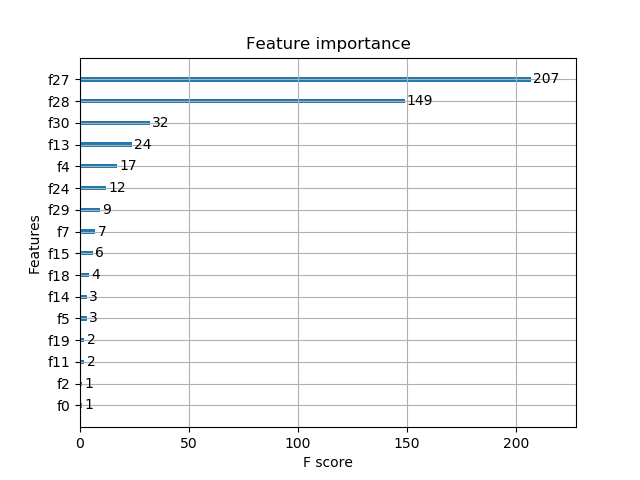

In [37]:
display(plot_importance(classifier).figure)

In [38]:
# use feature importance for feature selection
from numpy import sort
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel

model = XGBClassifier()
model.fit(X_train, y_train)

# Fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
	# select features using threshold
	selection = SelectFromModel(model, threshold=thresh, prefit=True)
	select_X_train = selection.transform(X_train)
	# train model
	selection_model = XGBClassifier()
	selection_model.fit(select_X_train, y_train)
	# eval model
	select_X_vali = selection.transform(X_vali)
	y_pred = selection_model.predict_proba(select_X_vali)
	ap_value = average_precision_score(y_vali, y_pred[:,1])
	print("Thresh=%.3f, n=%d, Average_precision: %.2f%%" % (thresh, select_X_train.shape[1], ap_value*100.0))

Thresh=0.000, n=31, Average_precision: 90.20%
Thresh=0.000, n=31, Average_precision: 90.20%
Thresh=0.000, n=31, Average_precision: 90.20%
Thresh=0.000, n=31, Average_precision: 90.20%
Thresh=0.000, n=31, Average_precision: 90.20%
Thresh=0.000, n=31, Average_precision: 90.20%
Thresh=0.000, n=31, Average_precision: 90.20%
Thresh=0.000, n=31, Average_precision: 90.20%
Thresh=0.000, n=31, Average_precision: 90.20%
Thresh=0.000, n=31, Average_precision: 90.20%
Thresh=0.000, n=31, Average_precision: 90.20%
Thresh=0.000, n=31, Average_precision: 90.20%
Thresh=0.000, n=31, Average_precision: 90.20%
Thresh=0.000, n=31, Average_precision: 90.20%
Thresh=0.000, n=31, Average_precision: 90.20%
Thresh=0.006, n=16, Average_precision: 90.20%
Thresh=0.007, n=15, Average_precision: 90.19%
Thresh=0.007, n=14, Average_precision: 90.22%
Thresh=0.007, n=13, Average_precision: 90.21%
Thresh=0.007, n=12, Average_precision: 90.13%
Thresh=0.008, n=11, Average_precision: 90.09%
Thresh=0.015, n=10, Average_precision: 90.00%
Thresh=0.019, n=9, Average_precision: 90.07%
Thresh=0.024, n=8, Average_precision: 89.86%
Thresh=0.024, n=7, Average_precision: 89.86%
Thresh=0.024, n=6, Average_precision: 89.81%
Thresh=0.029, n=5, Average_precision: 89.27%
Thresh=0.082, n=4, Average_precision: 89.07%
Thresh=0.195, n=3, Average_precision: 88.73%
Thresh=0.269, n=2, Average_precision: 66.38%
Thresh=0.274, n=1, Average_precision: 68.88%

### xgboost调参数

In [40]:
eta = [0.05,0.1,0.15] 
max_depth = [6,7,8] 
n_estimators = [100,300,500] 
ap_value = []

for lr in eta:
  for depth in max_depth:
    for n in n_estimators:
      model = XGBClassifier(learning_rate=lr,
                      n_estimators=n,         # 树的个数--棵树建立xgboost
                      max_depth=depth,               # 树的深度
                      min_child_weight = 1,      # 叶子节点最小权重
                      gamma=0.,                  # 惩罚项中叶子结点个数前的参数
                      subsample=0.8,             # 随机选择80%样本建立树
                      colsample_btree=0.8,       # 随机算哦80%样本选择特征
                      scale_pos_weight=1,        # 解决样本个数不平衡的问题
                      random_state=27            # 随机数
                      )
      
      model.fit(X_train, y_train)
      y_pred_xg = model.predict_proba(X_vali)
      outcome = average_precision_score(y_vali, y_pred_xg[:,1]) 
      ap_value.append(outcome)
      print('learning rate',lr,'max depth',depth,'n_estimator',n,'apvalue',outcome)

learning rate 0.05 max depth 6 n_estimator 100 apvalue 0.9087210596957158
learning rate 0.05 max depth 6 n_estimator 300 apvalue 0.9047359467070452
learning rate 0.05 max depth 6 n_estimator 500 apvalue 0.8997415279787586
learning rate 0.05 max depth 7 n_estimator 100 apvalue 0.9070985689714364
learning rate 0.05 max depth 7 n_estimator 300 apvalue 0.9019102709484512
learning rate 0.05 max depth 7 n_estimator 500 apvalue 0.8969073708283402
learning rate 0.05 max depth 8 n_estimator 100 apvalue 0.9048191184221787
learning rate 0.05 max depth 8 n_estimator 300 apvalue 0.8977490011259893
learning rate 0.05 max depth 8 n_estimator 500 apvalue 0.8925742744101495
learning rate 0.1 max depth 6 n_estimator 100 apvalue 0.9073242598007832
learning rate 0.1 max depth 6 n_estimator 300 apvalue 0.8969746335674947
learning rate 0.1 max depth 6 n_estimator 500 apvalue 0.8917430507654619
learning rate 0.1 max depth 7 n_estimator 100 apvalue 0.9049980730429368
learning rate 0.1 max depth 7 n_estimator 300 apvalue 0.8931091897750106
learning rate 0.1 max depth 7 n_estimator 500 apvalue 0.8892388893160902
learning rate 0.1 max depth 8 n_estimator 100 apvalue 0.9011995569738239
learning rate 0.1 max depth 8 n_estimator 300 apvalue 0.890506353575368
learning rate 0.1 max depth 8 n_estimator 500 apvalue 0.8852402081511506
learning rate 0.15 max depth 6 n_estimator 100 apvalue 0.9011623321180883
learning rate 0.15 max depth 6 n_estimator 300 apvalue 0.8888778244109083
learning rate 0.15 max depth 6 n_estimator 500 apvalue 0.8859171434859795
learning rate 0.15 max depth 7 n_estimator 100 apvalue 0.899342565361307
learning rate 0.15 max depth 7 n_estimator 300 apvalue 0.8842974493503338
learning rate 0.15 max depth 7 n_estimator 500 apvalue 0.881566806303118
learning rate 0.15 max depth 8 n_estimator 100 apvalue 0.897848953101152
learning rate 0.15 max depth 8 n_estimator 300 apvalue 0.8859248922897687
learning rate 0.15 max depth 8 n_estimator 500 apvalue 0.8812799661156143

In [41]:
max(ap_value)
# learning rate 0.05 max depth 6 n_estimator 100 apvalue 0.9087210596957158

Out[222]: 0.9087210596957158

#### 着重于learning rate

In [43]:
eta = [0.03,0.04,0.05,0.06,0.07,0.08] 

ap_value2 = []

for lr in eta:
  
    model = XGBClassifier(learning_rate=lr,
                    n_estimators=100,         # 树的个数--棵树建立xgboost
                    max_depth=6,               # 树的深度
                    min_child_weight = 1,      # 叶子节点最小权重
                    gamma=0.,                  # 惩罚项中叶子结点个数前的参数
                    subsample=0.8,             # 随机选择80%样本建立树
                    colsample_btree=0.8,       # 随机算哦80%样本选择特征
                    scale_pos_weight=1,        # 解决样本个数不平衡的问题
                    random_state=27            # 随机数
                    )

    model.fit(X_train, y_train)
    y_pred_xg = model.predict_proba(X_vali)
    outcome = average_precision_score(y_vali, y_pred_xg[:,1]) 
    ap_value2.append(outcome)
    print('learning rate',lr,'APvalue',outcome)

learning rate 0.03 APvalue 0.9069704557588716
learning rate 0.04 APvalue 0.9083612031145889
learning rate 0.05 APvalue 0.9087210596957158
learning rate 0.06 APvalue 0.9087265397974215
learning rate 0.07 APvalue 0.9074812866409464
learning rate 0.08 APvalue 0.9081622509838376

In [44]:
max(ap_value2)

Out[227]: 0.9087265397974215

#### 选取参数：learning_rate = 0.06, 树的个数 100，树的深度 6，做特征选择=>根据结果不需要去掉任何特征

In [46]:
model = XGBClassifier(learning_rate=0.06,
                    n_estimators=100,         # 树的个数--棵树建立xgboost
                    max_depth=6,               # 树的深度
                    min_child_weight = 1,      # 叶子节点最小权重
                    gamma=0.,                  # 惩罚项中叶子结点个数前的参数
                    subsample=0.8,             # 随机选择80%样本建立树
                    colsample_btree=0.8,       # 随机算哦80%样本选择特征
                    scale_pos_weight=1,        # 解决样本个数不平衡的问题
                    random_state=27            # 随机数
                    )

model.fit(X_train, y_train)

# Fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)

for thresh in thresholds:
	# select features using threshold
	selection = SelectFromModel(model, threshold=thresh, prefit=True)
	select_X_train = selection.transform(X_train)
	# train model
	selection_model = XGBClassifier()
	selection_model.fit(select_X_train, y_train)
	# eval model
	select_X_vali = selection.transform(X_vali)
	y_pred = selection_model.predict_proba(select_X_vali)
	ap_value = average_precision_score(y_vali, y_pred[:,1])
	print("Thresh=%.6f, n=%d, Average_precision: %.6f%%" % (thresh, select_X_train.shape[1], ap_value*100.0))

Thresh=0.000000, n=31, Average_precision: 90.199770%
Thresh=0.000000, n=31, Average_precision: 90.199770%
Thresh=0.000000, n=31, Average_precision: 90.199770%
Thresh=0.000000, n=31, Average_precision: 90.199770%
Thresh=0.000000, n=31, Average_precision: 90.199770%
Thresh=0.000000, n=31, Average_precision: 90.199770%
Thresh=0.000000, n=31, Average_precision: 90.199770%
Thresh=0.007566, n=24, Average_precision: 90.199770%
Thresh=0.008891, n=23, Average_precision: 90.177810%
Thresh=0.009357, n=22, Average_precision: 90.126871%
Thresh=0.010029, n=21, Average_precision: 90.126871%
Thresh=0.010940, n=20, Average_precision: 90.126871%
Thresh=0.011364, n=19, Average_precision: 90.120569%
Thresh=0.011827, n=18, Average_precision: 90.120569%
Thresh=0.011886, n=17, Average_precision: 90.129203%
Thresh=0.011985, n=16, Average_precision: 89.954883%
Thresh=0.012144, n=15, Average_precision: 89.954883%
Thresh=0.013372, n=14, Average_precision: 89.954883%
Thresh=0.013966, n=13, Average_precision: 90.016156%
Thresh=0.014442, n=12, Average_precision: 90.016156%
Thresh=0.015636, n=11, Average_precision: 90.016156%
Thresh=0.016135, n=10, Average_precision: 89.895466%
Thresh=0.018644, n=9, Average_precision: 89.855099%
Thresh=0.019334, n=8, Average_precision: 89.055271%
Thresh=0.022057, n=7, Average_precision: 89.147517%
Thresh=0.026251, n=6, Average_precision: 89.147517%
Thresh=0.032631, n=5, Average_precision: 88.998086%
Thresh=0.040144, n=4, Average_precision: 89.072199%
Thresh=0.056057, n=3, Average_precision: 89.391345%
Thresh=0.147026, n=2, Average_precision: 89.250869%
Thresh=0.458316, n=1, Average_precision: 68.878846%

### 预测test数集

In [48]:
#用df_train做两个新的特征
t_emd1 = df_train.select("merchant_id","fraud").groupBy("fraud","merchant_id").count().groupBy("merchant_id").pivot("fraud").agg(f.first("count")).withColumn("fraud_ratio", f.col("1") / (f.col("0")+f.col("1"))) \
      .select("merchant_id","fraud_ratio").fillna(0, subset=["fraud_ratio"])
t_emb2 = df_train.select("merchant_id","amount","time").groupBy("merchant_id","time").agg(f.mean("amount").alias("avg_sales"),f.count("amount").alias("sales_ct")).select("merchant_id","time","avg_sales","sales_ct").fillna(0, subset=["avg_sales","sales_ct"])   

#将得到的特征通过join的形式赋予到df_train和df_test集
new_df_train = df_train.join(t_emd1,"merchant_id","left").join(t_emb2,["merchant_id","time"],"left")
new_df_test = df_test.join(t_emd1,"merchant_id","left").join(t_emb2,["merchant_id","time"],"left")

#将类型值用dummy处理，将数据值做normalization 
X_train_t = process_data(new_df_train)
y_train_t = np.array(new_df_train.select("fraud").collect(),dtype="float").astype(np.float32)

X_test_t = process_data(new_df_test)

In [49]:
model_t = XGBClassifier(learning_rate=0.06,
                    n_estimators=100,         # 树的个数--100棵树建立xgboost
                    max_depth=6,               # 树的深度
                    min_child_weight = 1,      # 叶子节点最小权重
                    gamma=0.,                  # 惩罚项中叶子结点个数前的参数
                    subsample=0.8,             # 随机选择80%样本建立树
                    colsample_btree=0.8,       # 随机算哦80%样本选择特征
                    scale_pos_weight=1,        # 解决样本个数不平衡的问题
                    random_state=27            # 随机数
                    )
      
model_t.fit(X_train_t, y_train_t)
y_pred_test = model_t.predict_proba(X_test_t)

In [50]:
outcome = y_pred_test[:,1]
df_outcome = sqlContext.createDataFrame( [ (idx,float(i)) for idx,i in enumerate(outcome)],["id","result"])

In [51]:
display(df_outcome)

id,result
0,0.0012181237107142806
1,0.0012181237107142806
2,0.0012181237107142806
3,0.0012181237107142806
4,0.0012181237107142806
5,0.0012181237107142806
6,0.0012181237107142806
7,0.0012181237107142806
8,0.0012181237107142806
9,0.0012181237107142806
